In [2]:
import pybinding as pb
import numpy as np
from numpy import sqrt as sqrt
import matplotlib.pyplot as plt
from numpy import exp, dot, einsum, cos, sin, pi
import sympy as sp
import cmath

In [29]:
a = 1 #lattice constant
def rice_mele(t, T=1, v=1):
    # onsite energies
    omega = 2*np.pi/T
    u_t = np.sin(omega*t)
    v_t = v + np.cos(omega*t)
    Ea = u_t
    Eb = -u_t

    w_t = 1
    a1 = np.array([a, 0])
    rice_mele_lattice = pb.Lattice(a1=a1)
    rice_mele_lattice.add_sublattices(
        ('A', np.array([0]), Ea), ('B', np.array([a/2]), Eb))  # add an atom called 'A' at position [0, 0]    
    rice_mele_lattice.add_hoppings(
        ([0], 'A', 'B', v_t),
        ([1], 'B', 'A', w_t),
    )
    rice_mele_model = pb.Model(
        rice_mele_lattice,
        pb.translational_symmetry()
    )
    return rice_mele_model

def rice_mele_finite(t, T=1, v=1, N=40):
    # onsite energies
    omega = 2*np.pi/T
    u_t = np.sin(omega*t)
    v_t = v + np.cos(omega*t)
    Ea = u_t
    Eb = -u_t

    w_t = 1
    a1 = np.array([a*N, 0])
    rice_mele_lattice = pb.Lattice(a1=a1)
    for n in range(0, N):
        rice_mele_lattice.add_sublattices(
            (f'A{n}', np.array([n*a]), Ea), (f'B{n}', np.array([n*a+a/2]), Eb))  # add an atom called 'A' at position [0, 0] 
    for n in range(0, N):
        rice_mele_lattice.add_hoppings(
            ([0], f'A{n}', f'B{n}', v_t)
        )
    for n in range(0, N-1):
        rice_mele_lattice.add_hoppings(
            ([0], f'B{n}', f'A{n+1}', w_t)
        )
    rice_mele_model = pb.Model(
        rice_mele_lattice,
    )
    return rice_mele_model

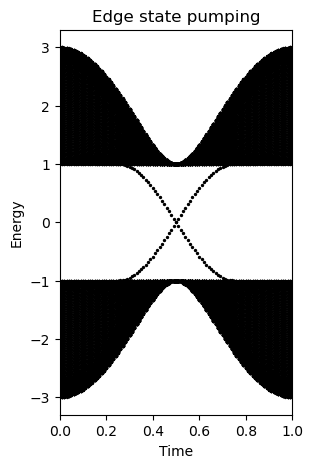

In [46]:
plt.figure(figsize=(3, 5))
N = 100
T = 1
for i in range(0, N+1):
    t = T*i/N
    rice_mele_model = rice_mele_finite(t, T=T, N=100)
    solver = pb.solver.lapack(rice_mele_model)    
    rice_mele_energies = solver.eigenvalues
    k_path = bands.k_path
    plt.scatter(np.ones(rice_mele_energies.shape[0])*t, rice_mele_energies, color="black", s=2);
plt.xlim(0, T)
plt.title("Edge state pumping")
plt.xlabel("Time")
plt.ylabel("Energy");

# Calculating the Berry phase

In [71]:
N1 = 50
N2 = 200
T = 1
psi_last = np.zeros(2, dtype=complex) 
psi_prev = np.zeros(2, dtype=complex) 

berry_phases = np.array([])
for t1 in range(0, N2+1):
    t = (t1/N2)*T
    rice_mele_model = rice_mele(t, T=T)
    solver = pb.solver.lapack(rice_mele_model)
    berry_phase = 1

    for k1 in range(0, N1):
        k = 2*np.pi * k1/N1
        delta_k_1 = 2*np.pi/N1
        solver.set_wave_vector(k)
        psi_0 = solver.eigenvectors[:, 0]
        if k1 == 0:
            psi_last = psi_0
        solver.set_wave_vector(k + delta_k_1)
        psi_1 = solver.eigenvectors[:, 0]
        if k1 == N1-1: 
            overlap = np.einsum("i, i->", np.conj(psi_0), psi_last)
        elif k1 == 0:
            overlap = np.einsum("i, i->", np.conj(psi_0), psi_1)
        else:
            overlap = np.einsum("i, i->", np.conj(psi_prev), psi_1)
        psi_prev = psi_1
    
        berry_phase *= overlap    
    berry_phase = cmath.phase(berry_phase)
    berry_phases = np.append(berry_phases, berry_phase)

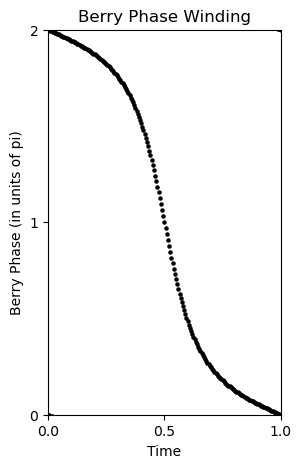

In [79]:
plt.figure(figsize=(3, 5))
plt.scatter(np.linspace(0, 1, N2+1), -berry_phases/np.pi, s=5, color="black")
plt.scatter(np.linspace(0, 1, N2+1), 2-berry_phases/np.pi, s=5, color="black")
plt.scatter(np.linspace(0, 1, N2+1), -2-berry_phases/np.pi, s=5, color="black")
plt.ylim(0, 2)
plt.xlim(0, 1)
plt.title("Berry Phase Winding");
plt.xticks([0, 0.5, 1]);
plt.yticks([0, 1, 2]);
plt.ylabel("Berry Phase (in units of pi)")
plt.xlabel("Time");